In [4]:
!pip install tensorflow keras scikit-learn pandas numpy matplotlib

In [5]:
import pandas as pd

df = pd.read_csv("/content/clean_cv_data.csv")
print(df.head())
print(df['main_label'].value_counts())

                                          clean_text main_label   sub_label
0                                 Jitesh Vishwakarma       meta      others
1             E-mail-Id: - jvishwakarma123@gmail.com       meta      others
2                       Contact Number: - 9960902548       meta      others
3                              PROFESSIONAL SUMMARY:     header  experience
4  · 4 years of technical experience in implement...    content  experience
main_label
content    27341
meta        7311
header      5349
Name: count, dtype: int64


In [6]:
from sklearn.preprocessing import LabelEncoder

TEXT_COL  = "clean_text"
LABEL_COL = "main_label"

le = LabelEncoder()
y_all = le.fit_transform(df[LABEL_COL])
num_classes = len(le.classes_)
print("Sınıf sayısı:", num_classes, "\nSınıflar:", list(le.classes_))

Sınıf sayısı: 3 
Sınıflar: ['content', 'header', 'meta']


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COL], y_all, test_size=0.20, stratify=y_all, random_state=42
)

# train'den küçük bir validation ayır
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

len(X_train), len(X_val), len(X_test)

(28800, 3200, 8001)

In [8]:
# Tokenization + Padding (düzeltilmiş)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 30000
OOV_TOKEN  = "<unk>"
MAX_LEN    = 200

tok = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tok.fit_on_texts(X_train.astype(str).tolist())

def to_seq(series):
    seqs = tok.texts_to_sequences(series.astype(str).tolist())
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

# --- sadece bu üç satır önemli: to_pad yerine to_seq ve *_seq isimleri ---
Xtr_seq = to_seq(X_train)
Xva_seq = to_seq(X_val)
Xte_seq = to_seq(X_test)

print(Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)

(28800, 200) (3200, 200) (8001, 200)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(np.unique(y_train))
vocab_size  = min(30000, len(tok.word_index) + 1)  # tok, bir önceki hücreden

def build_text_cnn(max_len=200, vocab_size=vocab_size, num_classes=num_classes,
                   emb_dim=128, conv_filters=128, drop=0.5):
    inp = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, emb_dim, input_length=max_len)(inp)

    b3 = layers.Conv1D(conv_filters, 3, activation="relu")(x)
    b4 = layers.Conv1D(conv_filters, 4, activation="relu")(x)
    b5 = layers.Conv1D(conv_filters, 5, activation="relu")(x)

    b3 = layers.GlobalMaxPooling1D()(b3)
    b4 = layers.GlobalMaxPooling1D()(b4)
    b5 = layers.GlobalMaxPooling1D()(b5)

    x = layers.concatenate([b3, b4, b5])
    x = layers.Dropout(drop)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inp, out)

model = build_text_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  2,160,256 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 198, 128)  │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 197, 128)  │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 196, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,406,915 (9.18 MB)

 Trainable params: 2,406,915 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_textcnn.keras", monitor="val_accuracy",
                                    save_best_only=True, mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3,
                                  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2,
                                      factor=0.5, verbose=1),
]

In [11]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
class_weight  # dengesizlik yoksa bunu kullanmayabilirsin


{0: 0.4876809753619507, 1: 2.4928589976629447, 2: 1.8237082066869301}

In [12]:
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(
    Xtr_seq, y_train,
    validation_data=(Xva_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weight if 'class_weight' in globals() else None
)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.6978 - loss: 0.7238 - val_accuracy: 0.8756 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8962 - loss: 0.3207 - val_accuracy: 0.8741 - val_loss: 0.3706 - learning_rate: 0.0010
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9189 - loss: 0.2308 - val_accuracy: 0.8753 - val_loss: 0.3787 - learning_rate: 0.0010
Epoch 4/10
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9286 - loss: 0.1969
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9286 - loss: 0.1969 - val_accuracy: 0.8603 - val_loss: 0.4271 - learning_rate: 0.0010


In [13]:
val_loss, val_acc = model.evaluate(Xva_seq, y_val, verbose=0)
print(f"Val Acc: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(Xte_seq, y_test, verbose=0)
print(f"Test Acc: {test_acc:.4f}")

Val Acc: 0.8756
Test Acc: 0.8720


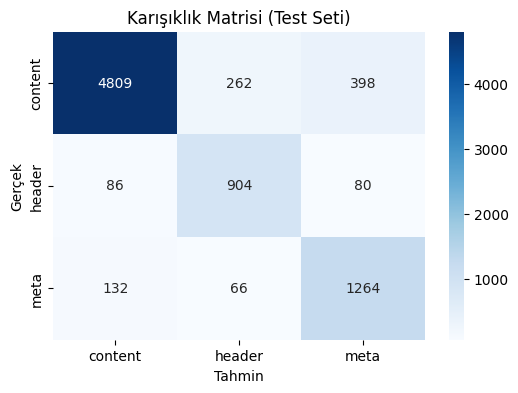

              precision    recall  f1-score   support

     content       0.96      0.88      0.92      5469
      header       0.73      0.84      0.79      1070
        meta       0.73      0.86      0.79      1462

    accuracy                           0.87      8001
   macro avg       0.81      0.86      0.83      8001
weighted avg       0.88      0.87      0.88      8001



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahmin al
y_pred = np.argmax(model.predict(Xte_seq, verbose=0), axis=1)

# Matris
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi (Test Seti)")
plt.show()

# Ayrıntılı skorlar
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [15]:
def predict_text(text):
    seq = pad_sequences(tok.texts_to_sequences([text]), maxlen=200, padding="post", truncating="post")
    probs = model.predict(seq, verbose=0)[0]
    pred = np.argmax(probs)
    return le.inverse_transform([pred])[0], float(probs[pred])

sample = "Contact Number: +90 505 123 4567"
predict_text(sample)

('meta', 0.9857281446456909)

In [16]:
model.save("textcnn_final.keras")
# Drive’a kopyalamak istersen:
# !cp textcnn_final.keras "/content/drive/MyDrive/proje/textcnn_final.keras"

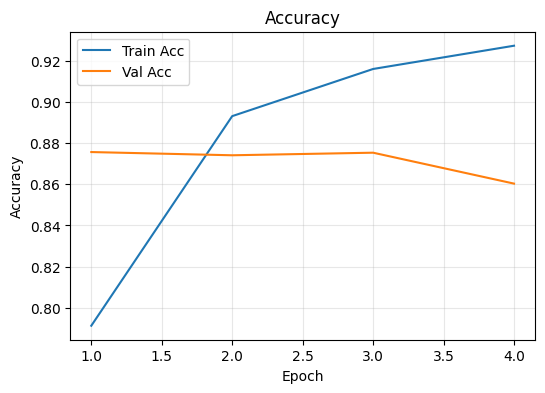

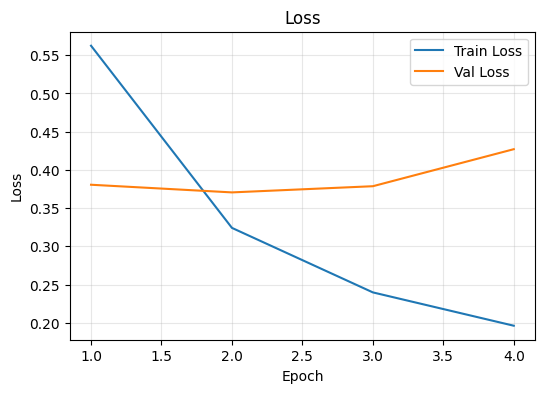

En iyi epoch (val acc’e göre): 1 | Val Acc: 0.8756


In [17]:
import matplotlib.pyplot as plt
import numpy as np

hist = history.history  # model.fit(...)'ten geliyor

epochs = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, hist["accuracy"], label="Train Acc")
plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, hist["loss"], label="Train Loss")
plt.plot(epochs, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_ep = int(np.argmax(hist["val_accuracy"]) + 1)
print(f"En iyi epoch (val acc’e göre): {best_ep} | Val Acc: {hist['val_accuracy'][best_ep-1]:.4f}")


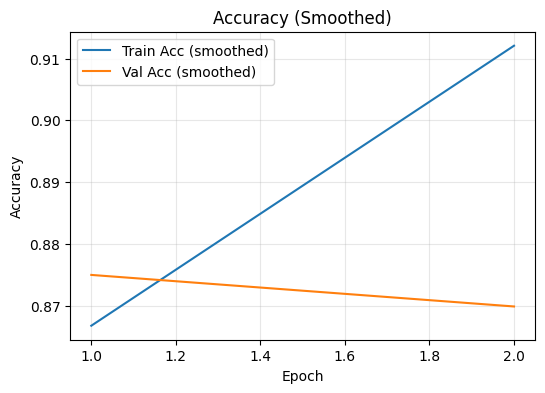

In [18]:
def smooth(xs, w=3):
    xs = np.array(xs, dtype=float)
    if len(xs) < w:
        return xs
    return np.convolve(xs, np.ones(w)/w, mode="valid")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(smooth(hist["accuracy"]))+1), smooth(hist["accuracy"]), label="Train Acc (smoothed)")
plt.plot(range(1, len(smooth(hist["val_accuracy"]))+1), smooth(hist["val_accuracy"]), label="Val Acc (smoothed)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy (Smoothed)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(np.unique(y_train))
vocab_size  = min(30000, len(tok.word_index) + 1)

def build_text_cnn(max_len=200, vocab_size=vocab_size, num_classes=num_classes,
                   emb_dim=96, conv_filters=128, drop=0.6, l2w=1e-4):
    inp = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, emb_dim, input_length=max_len)(inp)
    x = layers.SpatialDropout1D(0.2)(x)  # embedding seviyesinde düzenleme

    # 3-4-5 pencereler + L2
    b3 = layers.Conv1D(conv_filters, 3, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)
    b4 = layers.Conv1D(conv_filters, 4, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)
    b5 = layers.Conv1D(conv_filters, 5, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)

    b3 = layers.GlobalMaxPooling1D()(b3)
    b4 = layers.GlobalMaxPooling1D()(b4)
    b5 = layers.GlobalMaxPooling1D()(b5)

    x = layers.concatenate([b3, b4, b5])
    x = layers.Dropout(drop)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2w))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inp, out)

model = build_text_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 96)   │  1,620,192 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 96)   │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 198, 128)  │     36,992 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 197, 128)  │     49,280 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 196, 128)  │     61,568 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 384)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,817,699 (6.93 MB)

 Trainable params: 1,817,699 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2,
                                  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=1,
                                      factor=0.5, verbose=1)
]

In [21]:
EPOCHS = 8
BATCH_SIZE = 64

history = model.fit(
    Xtr_seq, y_train,
    validation_data=(Xva_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/8
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7146 - loss: 0.7253 - val_accuracy: 0.8847 - val_loss: 0.3739 - learning_rate: 5.0000e-04
Epoch 2/8
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9023 - loss: 0.3531 - val_accuracy: 0.9056 - val_loss: 0.3370 - learning_rate: 5.0000e-04
Epoch 3/8
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9213 - loss: 0.2829
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9213 - loss: 0.2830 - val_accuracy: 0.9041 - val_loss: 0.3380 - learning_rate: 5.0000e-04
Epoch 4/8
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9339 - loss: 0.2331
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9339 - loss: 0.2331 - val_accuracy: 0.8981 - val_loss: 0.3449 - learning_rate: 2.5000e-04


In [22]:
val_loss, val_acc = model.evaluate(Xva_seq, y_val, verbose=0)
test_loss, test_acc = model.evaluate(Xte_seq, y_test, verbose=0)
print(f"Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Val Acc: 0.9056 | Test Acc: 0.8951


In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Test set tahminleri
y_pred = np.argmax(model.predict(Xte_seq, verbose=0), axis=1)

print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df

              precision    recall  f1-score   support

     content       0.93      0.95      0.94      5469
      header       0.81      0.80      0.81      1070
        meta       0.83      0.76      0.80      1462

    accuracy                           0.90      8001
   macro avg       0.86      0.84      0.85      8001
weighted avg       0.89      0.90      0.89      8001



,content,header,meta
content,5191,102,176
header,167,854,49
meta,253,92,1117


In [24]:
# Yanlış sınıflanan ilk 20 örneği göster
wrong_idx = np.where(y_pred != y_test)[0][:20]
pd.DataFrame({
    "text": X_test.iloc[wrong_idx].values,
    "true": le.inverse_transform(y_test[wrong_idx]),
    "pred": le.inverse_transform(y_pred[wrong_idx])
})

,text,true,pred
0,EDUCATIONAL,content,header
1,WIFE: Presently on Pregnancy Leave,meta,content
2,Date: 02-Jan-2018,meta,content
3,HAVERI-581110-KARNATAKA,meta,content
4,situations and get that done successfully with...,meta,content
5,"Pollibetta,Nellikad Estate.",meta,content
6,I consider myself familiar with Information Te...,meta,content
7,RAMANATHAPURAM,meta,content
8,Sever Skill : Windows server 2008,header,content
9,Name : Lansforsakringar (LFAB),content,meta


In [25]:
import pickle, json

# modeli kaydet
model.save("textcnn_final.keras")

# tokenizer
with open("tokenizer.json", "w") as f:
    f.write(tok.to_json())

# label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# küçük bir tahmin yardımcı dosyası (opsiyonel)
def predict_text(text):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    seq = pad_sequences(tok.texts_to_sequences([str(text)]), maxlen=200, padding="post", truncating="post")
    probs = model.predict(seq, verbose=0)[0]
    pred = int(np.argmax(probs))
    return le.inverse_transform([pred])[0], float(probs[pred])

# Örnek
print(predict_text("Contact Number: +90 505 123 45 67"))

('meta', 0.602075457572937)


In [29]:
THRESH = 0.60  # emin değilse sınıflama yapma

def predict_with_threshold(text, thr=THRESH):
    seq = pad_sequences(tok.texts_to_sequences([str(text)]), maxlen=200, padding="post", truncating="post")
    probs = model.predict(seq, verbose=0)[0]
    cls_id = int(np.argmax(probs)); conf = float(probs[cls_id])
    if conf < thr:
        return "unknown", conf
    return le.inverse_transform([cls_id])[0], conf

# örnek
predict_with_threshold("Phone: +90 555 000 00 00")

('content', 0.9259937405586243)

In [30]:
import tensorflow as tf

# Kaydedilmiş modeli yükle (gerekirse)
# model = tf.keras.models.load_model("textcnn_final.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # daha küçük boyut
tflite_model = converter.convert()

with open("textcnn_final.tflite", "wb") as f:
    f.write(tflite_model)
print("TFLite boyutu (KB):", len(tflite_model)/1024)

Saved artifact at '/tmp/tmpxfy3fdrc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.int32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138559607251664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607244944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607245136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607244560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607251856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607245712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607244752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607250704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607249360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138559607244176: Tens

In [31]:
import numpy as np, tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="textcnn_final.tflite")
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]["index"]
out = interpreter.get_output_details()[0]["index"]

def tflite_predict(text):
    seq = pad_sequences(tok.texts_to_sequences([str(text)]), maxlen=200, padding="post", truncating="post").astype(np.int32)
    interpreter.set_tensor(inp, seq)
    interpreter.invoke()
    probs = interpreter.get_tensor(out)[0]
    cls = int(np.argmax(probs))
    return le.inverse_transform([cls])[0], float(probs[cls])

tflite_predict("E-mail: example@site.com")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


('content', 0.7863180637359619)

In [32]:
import numpy as np
# val set üzerinde logits almak için: son Dense öncesine küçük model kurmaya gerek yok,
# pratik yaklaşım: sıcaklık T ile softmax'ı yeniden hesaplayalım.

T = tf.Variable(1.0, dtype=tf.float32)

def softmax_with_T(logits, T):
    return tf.nn.softmax(logits / T, axis=-1)

# logits almak için küçük bir “logit-model” (son Dense katmanından önceki x'i yakalıyoruz)
logit_layer = model.layers[-1]           # Dense
prelogit_model = tf.keras.Model(model.input, logit_layer.input)

val_logits = prelogit_model.predict(Xva_seq, verbose=0)
val_targets = y_val

opt = tf.keras.optimizers.Adam(1e-2)
for _ in range(200):
    with tf.GradientTape() as tape:
        probs = softmax_with_T(val_logits, T)
        loss = tf.keras.losses.sparse_categorical_crossentropy(val_targets, probs)
        loss = tf.reduce_mean(loss)
    opt.apply_gradients([(tape.gradient(loss, [T])[0], T)])
float(T.numpy())
# kullanırken: probs = softmax_with_T(prelogit_model.predict(seq), T)

1.1761096715927124

In [33]:
def try_config(emb=96, conv=128, drop=0.6, lr=5e-4):
    m = build_text_cnn(emb_dim=emb, conv_filters=conv, drop=drop)
    m.compile(optimizer=keras.optimizers.Adam(lr), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = m.fit(Xtr_seq, y_train, validation_data=(Xva_seq, y_val),
              epochs=6, batch_size=64, verbose=0,
              callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)])
    return max(h.history["val_accuracy"])

grid = [
    (96,128,0.6,5e-4),
    (96,160,0.6,5e-4),
    (64,128,0.6,5e-4),
    (96,128,0.5,5e-4),
]
results = {cfg: try_config(*cfg) for cfg in grid}
results

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


{(96, 128, 0.6, 0.0005): 0.9018750190734863,
 (96, 160, 0.6, 0.0005): 0.8987500071525574,
 (64, 128, 0.6, 0.0005): 0.9037500023841858,
 (96, 128, 0.5, 0.0005): 0.9021875262260437}

In [34]:
def predict_batch(texts):
    seq = pad_sequences(tok.texts_to_sequences([str(t) for t in texts]), maxlen=200, padding="post", truncating="post")
    probs = model.predict(seq, verbose=0)
    preds = probs.argmax(axis=1)
    return [le.inverse_transform([p])[0] for p in preds], probs.max(axis=1).tolist()


In [35]:
import os, random, numpy as np, tensorflow as tf
def set_seed(s=42):
    os.environ["PYTHONHASHSEED"] = str(s)
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)
set_seed(42)

In [36]:
# 1) TEMEL HAZIRLIK
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

def set_seed(s=42):
    os.environ["PYTHONHASHSEED"]=str(s)
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)
set_seed(42)

num_classes = len(np.unique(y_train))
vocab_size  = min(30000, len(tok.word_index) + 1)


In [37]:
# 2) MODEL MİMARİSİ (emb=96, conv=128, drop=0.5)
def build_text_cnn(max_len=200, vocab_size=vocab_size, num_classes=num_classes,
                   emb_dim=96, conv_filters=128, drop=0.5, l2w=1e-4):
    inp = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, emb_dim)(inp)
    x = layers.SpatialDropout1D(0.2)(x)

    b3 = layers.Conv1D(conv_filters, 3, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)
    b4 = layers.Conv1D(conv_filters, 4, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)
    b5 = layers.Conv1D(conv_filters, 5, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(l2w))(x)

    b3 = layers.GlobalMaxPooling1D()(b3)
    b4 = layers.GlobalMaxPooling1D()(b4)
    b5 = layers.GlobalMaxPooling1D()(b5)

    x = layers.concatenate([b3, b4, b5])
    x = layers.Dropout(drop)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2w))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)

model = build_text_cnn()
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 200, 96)   │  1,620,192 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_5 │ (None, 200, 96)   │          0 │ embedding_6[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 198, 128)  │     36,992 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 197, 128)  │     49,280 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 196, 128)  │     61,568 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_18[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_19[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_20[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 384)       │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     49,280 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        387 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,817,699 (6.93 MB)

 Trainable params: 1,817,699 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# 3) COMPILE + TRAIN
model.compile(optimizer=keras.optimizers.Adam(5e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
]

history = model.fit(
    Xtr_seq, y_train,
    validation_data=(Xva_seq, y_val),
    epochs=12, batch_size=64,
    callbacks=callbacks, verbose=1
)

# hızlı kontrol
val_loss, val_acc = model.evaluate(Xva_seq, y_val, verbose=0)
test_loss, test_acc = model.evaluate(Xte_seq, y_test, verbose=0)
print(f"Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/12
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7257 - loss: 0.7142 - val_accuracy: 0.8941 - val_loss: 0.3684
Epoch 2/12
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8962 - loss: 0.3751 - val_accuracy: 0.9016 - val_loss: 0.3473
Epoch 3/12
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9141 - loss: 0.2991 - val_accuracy: 0.8969 - val_loss: 0.3558
Epoch 4/12
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9244 - loss: 0.2506 - val_accuracy: 0.8984 - val_loss: 0.3738
Val Acc: 0.9016 | Test Acc: 0.8949


In [39]:
# 4) TEMPERATURE SCALING (kalibrasyon)
T = tf.Variable(1.0, dtype=tf.float32)

# son Dense öncesi aktivasyonu almak için "prelogit" model
logit_layer = model.layers[-1]                 # Dense
prelogit_model = keras.Model(model.input, logit_layer.input)

val_logits = prelogit_model.predict(Xva_seq, verbose=0)
val_targets = y_val

def softmax_with_T(logits, T):
    return tf.nn.softmax(logits / T, axis=-1)

opt = tf.keras.optimizers.Adam(1e-2)
for _ in range(200):
    with tf.GradientTape() as tape:
        probs = softmax_with_T(val_logits, T)
        loss = tf.keras.losses.sparse_categorical_crossentropy(val_targets, probs)
        loss = tf.reduce_mean(loss)
    opt.apply_gradients([(tape.gradient(loss, [T])[0], T)])

print("Öğrenilen T:", float(T.numpy()))

Öğrenilen T: 0.4652942419052124


In [40]:
# 5) PREDICT (kalibre + threshold)
THRESH = 0.68  # istersen 0.65–0.70 aralığında dene

def predict_with_T(text, thr=THRESH):
    seq = pad_sequences(tok.texts_to_sequences([str(text)]), maxlen=200, padding="post", truncating="post")
    logits = prelogit_model.predict(seq, verbose=0)
    probs  = tf.nn.softmax(logits / T).numpy()[0]
    cls_id = int(np.argmax(probs)); conf = float(probs[cls_id])
    if conf < thr:
        return "unknown", conf
    return le.inverse_transform([cls_id])[0], conf

# örnek
print(predict_with_T("Contact Number: +90 505 123 45 67"))

('unknown', 0.02685798518359661)


In [41]:
# 6) EXPORT
import pickle, json, pathlib

model.save("textcnn_final.keras")

with open("tokenizer.json", "w") as f:
    f.write(tok.to_json())

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# T değerini da kaydedelim
with open("temperature.txt", "w") as f:
    f.write(str(float(T.numpy())))

print("Kaydedildi: textcnn_final.keras, tokenizer.json, label_encoder.pkl, temperature.txt")


Kaydedildi: textcnn_final.keras, tokenizer.json, label_encoder.pkl, temperature.txt


In [42]:
# 7) TFLITE CONVERT + TEST
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("textcnn_final.tflite", "wb") as f: f.write(tflite_model)
print("TFLite boyutu (KB):", len(tflite_model)/1024)

# TFLite test (kalibrasyon TFLite'da yok; sadece sınıf tahmini)
interpreter = tf.lite.Interpreter(model_path="textcnn_final.tflite")
interpreter.allocate_tensors()
inp_idx = interpreter.get_input_details()[0]["index"]
out_idx = interpreter.get_output_details()[0]["index"]

def tflite_predict(text):
    seq = pad_sequences(tok.texts_to_sequences([str(text)]), maxlen=200, padding="post", truncating="post").astype(np.int32)
    interpreter.set_tensor(inp_idx, seq)
    interpreter.invoke()
    probs = interpreter.get_tensor(out_idx)[0]
    cls = int(np.argmax(probs))
    return le.inverse_transform([cls])[0], float(probs[cls])

print(tflite_predict("E-mail: example@site.com"))


Saved artifact at '/tmp/tmpnyifwwst'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.int32, name='keras_tensor_83')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138557161826896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161820176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161816912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161821328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161832272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161832080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161820944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161819216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161822288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161829968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138557161818640: Tens

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [43]:
# 8) PAKETLEME (opsiyonel)
import zipfile
with zipfile.ZipFile("textcnn_export.zip", "w", zipfile.ZIP_DEFLATED) as z:
    for f in ["textcnn_final.keras", "tokenizer.json", "label_encoder.pkl", "temperature.txt", "textcnn_final.tflite"]:
        z.write(f)
print("Hazır: textcnn_export.zip")

Hazır: textcnn_export.zip
